![workflow](images/topic_workflow.jpg)

# Loading the dataset

In [1]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

In [2]:
n_samples = 2000

newsgroups = fetch_20newsgroups(shuffle=True, random_state=27)
topic_names = newsgroups.target_names

X = newsgroups.data[:n_samples]
targets = [topic_names[target] for target in newsgroups.target][:n_samples]

# Save on computer memory by deleting large unsued variables
del newsgroups

print(f'Sample datapoint:\n{X[0]}')
print(f'Sample datapoint labeled topic: {targets[0]}')
print(f'\nTopic names:\n{topic_names}')

Sample datapoint:
From: brucek@Ingres.COM (Bruce Kleinman)
Subject: Re: Jewish Baseball Players?
Article-I.D.: pony.1993Apr15.223040.8733
Organization: Ingres Corporation, A subsidiary of The ASK Group, Inc.
Lines: 12

In article <15APR93.14691229.0062@lafibm.lafayette.edu> VB30@lafibm.lafayette.edu (VB30) writes:
>Just wondering.  A friend and I were talking the other day, and
>we were (for some reason) trying to come up with names of Jewish
>baseball players, past and present.  We weren't able to come up
>with much, except for Sandy Koufax, (somebody) Stankowitz, and
>maybe John Lowenstein.  Can anyone come up with any more.  I know
>it sounds pretty lame to be racking our brains over this, but
>humor us.  Thanks for your help.

Hank Greenberg, Sid Gordon, Ron Blomberg.

Guess it goes from the sublime to the ridiculous.

Sample datapoint labeled topic: rec.sport.baseball

Topic names:
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.ma

# Preprocessing to a numeric representation

#### "Normalizing" the text
We want our topic model to identify interesting and important patterns instead of noise. For that we need to "normalize" our text. Preprocessing is a crucial step when you do topic modeling and it markedly affects the results. For this example, let's use a popular Python NLP library called [spaCy](https://spacy.io/). It is a fast, easy-to-use, industrial-strength, and a powerful library. 

spaCy is a powerful library and it can do many other things, but we'll be using it for preprocessing.  With this library, you can run the NLP pipeline by simply calling the function `nlp`. You can then access information about each token in a `for` loop. 

```
doc = nlp(text)
for token in doc:
    print(token.pos_)
    print(token.lemma_)
```

#### Create word frequency counts
The LDA model finds topics based on word frequencies, so you must use a `CountVectorizer` to create a Bag of Words representation of each document.

In [3]:
import re
import spacy
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [4]:
nlp = spacy.load("en_core_web_sm")

def normalize_text(documents, 
                   min_token_len=2, 
                   irrelevant_pos=['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE']):
    """
    Given text, min_token_len, and irrelevant_pos carry out preprocessing of the text 
    and return a preprocessed string. 
    
    Keyword arguments:
    documents -- (np.array[str]) the list of documents to be preprocessed
    min_token_len -- (int) min_token_length required
    irrelevant_pos -- (list) a list of irrelevant pos tags
    
    Returns: np.array[str] the normalized documents
    """
    normalized_documents = []
    
    for text in documents:
        # Remove Emails
        text = re.sub(r'\S*@\S*\s?', '', text)

        # Remove extra space characters
        text = re.sub(r'\s+', ' ', text)

        # Remove distracting characters
        text = re.sub(r'''[\*\~]+''', "", text)

        doc = nlp(text)
        clean_text = []

        for token in doc:
            if (token.is_stop == False # Check if it's not a stopword
                and token.is_alpha # Check if it's an alphanumerics char
                and len(token) > min_token_len # Check if the word meets minimum threshold
                and token.pos_ not in irrelevant_pos): # Check if the POS is in the acceptable POS tags
                lemma = token.lemma_ # Take the lemma of the word
                clean_text.append(lemma)
                
        clean_text = ' '.join(clean_text)
        normalized_documents.append(clean_text)
        
    normalized_documents = np.array(normalized_documents)
    return normalized_documents

# Create a Transformer from the function so that we can use it in a Pipeline
normalizer = FunctionTransformer(normalize_text)

# Show an example of the normalizer in action
print(f'Prior to normalization:\n{X[0]}')
print(f'After normalization:\n{normalizer.transform(X[0:1])}')

Prior to normalization:
From: brucek@Ingres.COM (Bruce Kleinman)
Subject: Re: Jewish Baseball Players?
Article-I.D.: pony.1993Apr15.223040.8733
Organization: Ingres Corporation, A subsidiary of The ASK Group, Inc.
Lines: 12

In article <15APR93.14691229.0062@lafibm.lafayette.edu> VB30@lafibm.lafayette.edu (VB30) writes:
>Just wondering.  A friend and I were talking the other day, and
>we were (for some reason) trying to come up with names of Jewish
>baseball players, past and present.  We weren't able to come up
>with much, except for Sandy Koufax, (somebody) Stankowitz, and
>maybe John Lowenstein.  Can anyone come up with any more.  I know
>it sounds pretty lame to be racking our brains over this, but
>humor us.  Thanks for your help.

Hank Greenberg, Sid Gordon, Ron Blomberg.

Guess it goes from the sublime to the ridiculous.

After normalization:
['Bruce Kleinman Subject jewish Baseball Players Article organization Ingres Corporation subsidiary ASK Group line article write wonder fr

In [5]:
n_features = 5000

vectorizer = CountVectorizer(min_df=2, max_df=0.95, max_features=n_features)

In [6]:
preprocessor = Pipeline([('normalizer', normalizer), 
                         ('vectorizer', vectorizer)])

# Modeling

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import set_config

set_config(display='diagram')

In [8]:
n_topics = 10

lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=5,
                                learning_method='online',
                                random_state=27)

pipeline = Pipeline([('preprocessor', preprocessor), 
                     ('model', lda)])
pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('normalizer',
                                  FunctionTransformer(func=<function normalize_text at 0x7f3eced48e60>)),
                                 ('vectorizer',
                                  CountVectorizer(max_df=0.95,
                                                  max_features=5000,
                                                  min_df=2))])),
                ('model',
                 LatentDirichletAllocation(learning_method='online', max_iter=5,
                                           random_state=27))])

In [9]:
# Let's what the predictions look like for a datapoint.
# As discussed, we should get a probability distribution over n_topics
pipeline.transform(X[0:1])[0]

array([0.00232588, 0.27871643, 0.00232587, 0.19150254, 0.00232603,
       0.00232624, 0.51349908, 0.00232563, 0.0023261 , 0.0023262 ])

# Explore topics

After fitting LDA, we need to do some work to try and understand
what the fitted topics represent. 

One way to do this is to find out which are the most important words per topic. For this, we can look at the `lda.components_`
attribute, which is a `float` matrix of shape `(n_topics, n_words)` signifying each word's importance to a given topic.

We can also do this visualization with the convenient `pyLDAvis` package, which will also show us a low-dimensional representation of the topics so that we can see their relative similarities.

In [10]:
from matplotlib import pyplot as plt
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()

/home/eric/anaconda3/envs/lighthouse/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


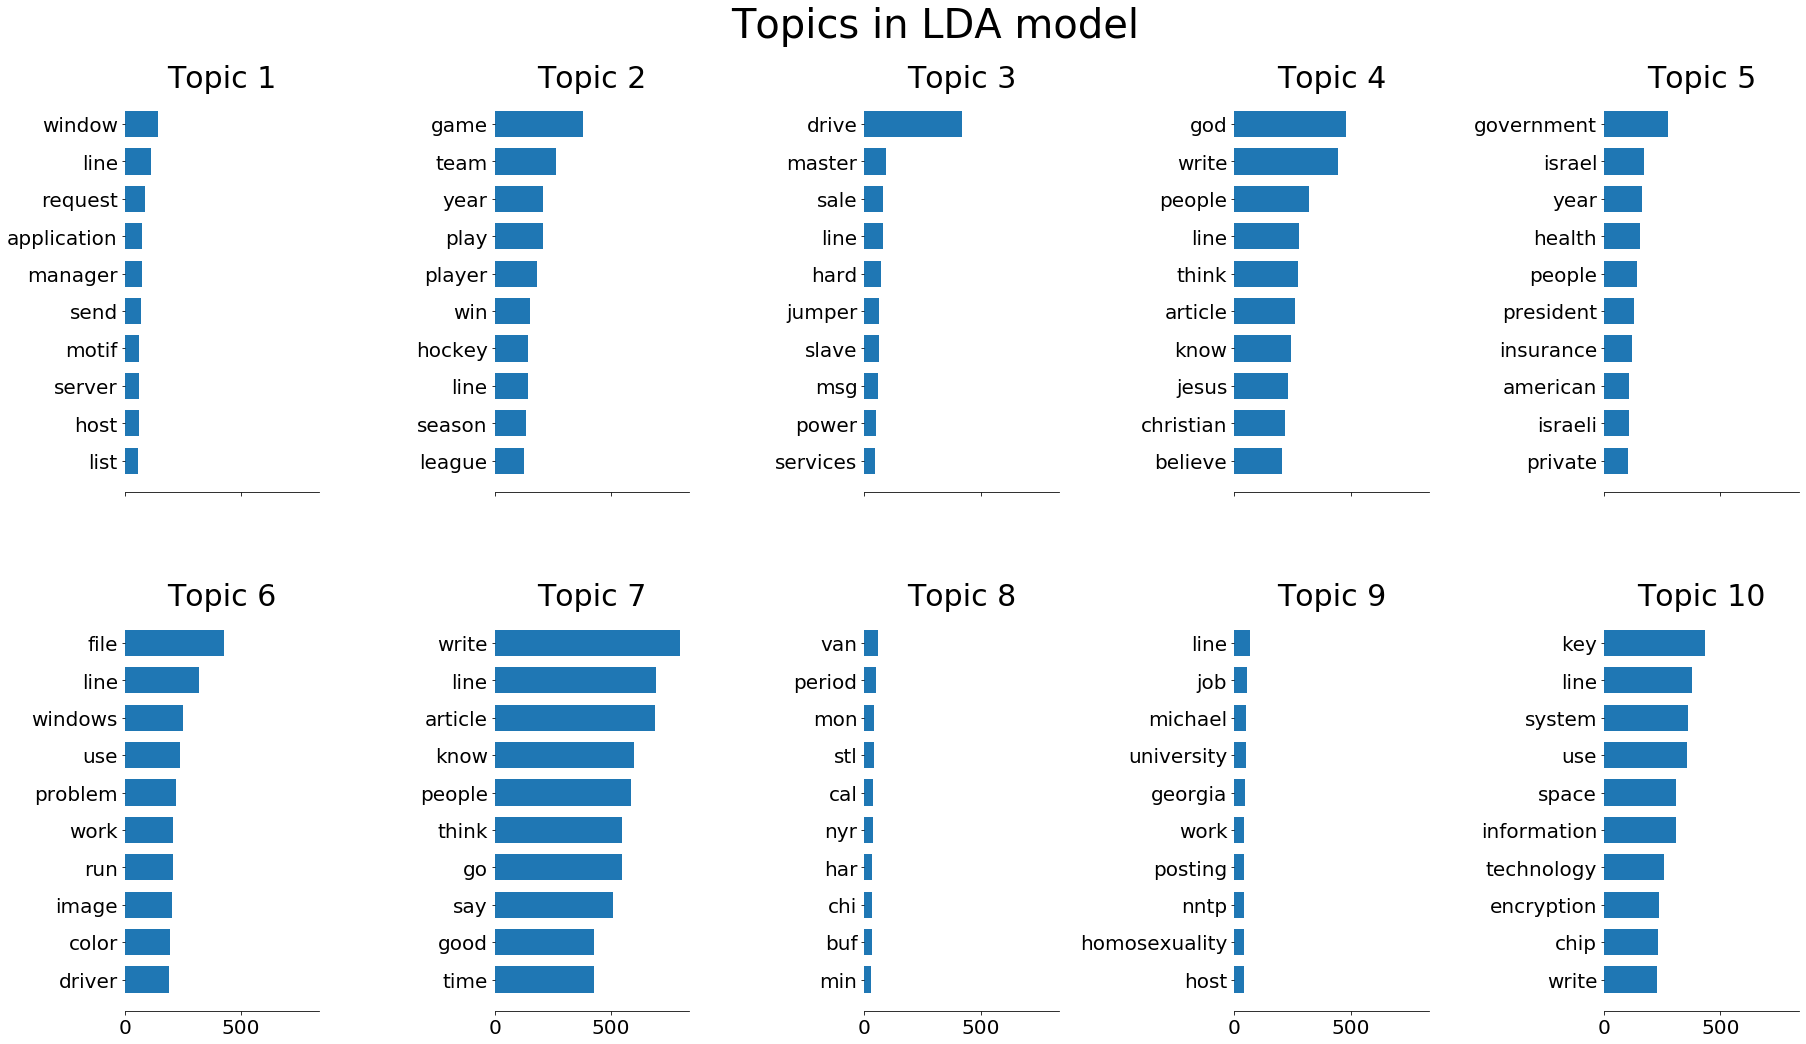

In [11]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
plot_top_words(lda, vectorizer.get_feature_names(), 10, 'Topics in LDA model')

In [13]:
data_vectorized = preprocessor.transform(X)
vis = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
vis

/home/eric/anaconda3/envs/lighthouse/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  30.734703
9       0.648955  71.707100       2        1  17.004051
3      71.019684   9.971006       3        1  15.704470
5       3.785981  33.185135       4        1  10.559546
4     -42.666500  -9.222070       5        1   8.843883
1      -3.621689 -43.526516       6        1   8.266033
2      -3.632402  -4.171708       7        1   3.144126
0     -36.584400  35.804413       8        1   2.948956
8      44.391380  50.615383       9        1   1.936854
7      40.235809 -31.591665      10        1   0.857377, topic_info=       Term         Freq        Total Category  logprob  loglift
1394  drive   526.000000   526.000000  Default  30.0000  30.0000
2607   line  2041.000000  2041.000000  Default  29.0000  29.0000
1834   game   419.000000   419.000000  Default  28.0000  28.0000
1704   file   531.000000   531.000000  Default  27.0000  27.0000
1907    god   469.000000   469.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
3565    pts    10.899445    14.372926  Topic10  -5.1337   4.4824
580   brown    19.840476    44.689835  Topic10  -4.5347   3.9470
4086   shot    19.216791    78.196068  Topic10  -4.5666   3.3556
4909    win    22.047561   232.051908  Topic10  -4.4292   2.4053
3932   save    15.694391   171.897166  Topic10  -4.7691   2.3655

[680 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
57        4  0.971056  adaptec
57        7  0.016742  adaptec
60        2  0.954535      adb
67        1  0.076803  address
67        2  0.220810  address
...     ...       ...      ...
4990      3  0.052702    young
4990      5  0.177870    young
4990      6  0.138343    young
4990      8  0.111992    young
4990      9  0.131756    young

[1728 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 4, 6, 5, 2, 3, 1, 9, 8])